<a href="https://colab.research.google.com/github/prathamesh0902/STATS_630/blob/main/STATS_630_HW_1_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing and initializing Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#importing the data sets
train = pd.read_csv("si630w23-hw1.train.csv")
validation = pd.read_csv("si630w23-hw1.dev.csv")
test = pd.read_csv("si630w23-hw1.test.csv")

In [ ]:
train.head()

,text,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1


In [ ]:
train.sarcastic.value_counts()

0    2600
1     867
Name: sarcastic, dtype: int64

In [ ]:
#splitting the data into input and output values
X_train, y_train = train['text'].values, train['sarcastic'].values
X_val, y_val = validation['text'].values, validation['sarcastic'].values
X_test = test['text'].values

Creating a better tokeniser by taking words in lower cases and removing the special characters

In [ ]:
import re

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    
    return text

In [ ]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [ ]:
#Making count of words in all the data set
words_count = {}

for words in X_train:
    for word in words.split(" "):
        if word in words_count:
            words_count[word] += 1
        else:
            words_count[word] = 1

In [ ]:
#words_count

In [ ]:
words_counts = {i:words_count[i] for i in words_count if i!=0 }

In [ ]:
words_counts_sorted = sorted(words_counts.items(), key=lambda x:x[1], reverse = True)
#print(words_counts_sorted)

In [ ]:
#words_counts

In [ ]:
#Converting input data into a vector: bag of words
DICT_SIZE = 5000
WORDS_TO_INDEX = {j[0]:i for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}####### YOUR CODE HERE #######
INDEX_TO_WORDS = {i:j[0] for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}####### YOUR CODE HERE #######
ALL_WORDS = WORDS_TO_INDEX.keys()

def tokenize(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    new_key= [words_to_index[i] for i in text.split(" ") if i in words_to_index.keys()]
    result_vector[new_key]=1
    return result_vector

## Transformation into sparse Matirx

In [ ]:
from scipy import sparse as sp_sparse

In [ ]:
#conversion to sparse matrix
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(tokenize(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(tokenize(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(tokenize(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (3467, 5000)
X_val shape  (280, 5000)
X_test shape  (1400, 5000)


# Training the model with Logistic regression and SGD method

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [ ]:
X = X_train_mybag
Y = y_train
w = np.zeros(5000)
#Run from this cell

In [ ]:
#model prediction
def forward(x):
    return (1/(1+ np.exp(- x.dot(w))))

In [ ]:
#loss 
def loss(x, y_true, y_pred):
    return((y_true * x.dot(w))-np.log (1+ np.exp(x.dot(w))))

In [ ]:
# gradients
def gradient(x, y_true, y_pred):
    sigma = forward(x) - y_true
    gradient_b = sigma.dot(x)
    return gradient_b

In [ ]:
def give_class(y_pred, data_len):
  for i in range(data_len):
    if (y_pred[i]>0.5):
      y_pred[i] = 1
    else:
      y_pred[i] = 0
  return y_pred

In [ ]:
from sklearn.metrics import f1_score

def calc_f1_score(y_true, y_pred, data_len):
  y_pred = give_class(y_pred, data_len)
  return f1_score(y_true, y_pred)

In [ ]:
# Training
learning_rate = 0.00001
epoch_intervals = 100
n_iters = 20000
data_len = 3467
l_agg = np.array([])
y_array = np.array([])
y_agg = np.array([])
f_array = np.array([])
f1_scores = 0

for epoch in range(n_iters):
  l_array = np.array([])
  y_array = np.array([])
  for line in range(data_len):
      y_predicted = forward(X[line])
      l = loss(X[line].toarray(), Y[line], y_predicted)
      dw = gradient(X[line].toarray(), Y[line], y_predicted)
      w -= learning_rate * dw
      l_array = np.append(l_array,l)
      if (epoch % epoch_intervals == 0):
        y_array = np.append(y_array,y_predicted)      
  l_mean = l_array.mean()
  l_agg = np.append(l_agg,l_mean)
  if (epoch % epoch_intervals == 0):
    print('epoch:',epoch, '/',n_iters)
    f1_scores = calc_f1_score(Y, y_array, data_len)
    f_array = np.append(f_array,f1_scores)
    y_agg = np.append(y_agg,y_array)

epoch: 0 / 20000
epoch: 100 / 20000
epoch: 200 / 20000
epoch: 300 / 20000
epoch: 400 / 20000
epoch: 500 / 20000
epoch: 600 / 20000
epoch: 700 / 20000
epoch: 800 / 20000
epoch: 900 / 20000
epoch: 1000 / 20000
epoch: 1100 / 20000
epoch: 1200 / 20000
epoch: 1300 / 20000
epoch: 1400 / 20000
epoch: 1500 / 20000
epoch: 1600 / 20000
epoch: 1700 / 20000
epoch: 1800 / 20000
epoch: 1900 / 20000
epoch: 2000 / 20000
epoch: 2100 / 20000
epoch: 2200 / 20000
epoch: 2300 / 20000
epoch: 2400 / 20000
epoch: 2500 / 20000
epoch: 2600 / 20000
epoch: 2700 / 20000
epoch: 2800 / 20000
epoch: 2900 / 20000
epoch: 3000 / 20000
epoch: 3100 / 20000
epoch: 3200 / 20000
epoch: 3300 / 20000
epoch: 3400 / 20000
epoch: 3500 / 20000
epoch: 3600 / 20000
epoch: 3700 / 20000
epoch: 3800 / 20000
epoch: 3900 / 20000
epoch: 4000 / 20000
epoch: 4100 / 20000
epoch: 4200 / 20000
epoch: 4300 / 20000
epoch: 4400 / 20000
epoch: 4500 / 20000
epoch: 4600 / 20000
epoch: 4700 / 20000
epoch: 4800 / 20000
epoch: 4900 / 20000
epoch: 5000 

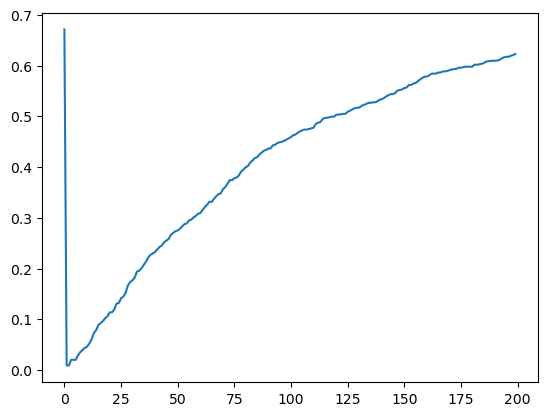

In [ ]:
_= plt.plot(f_array)

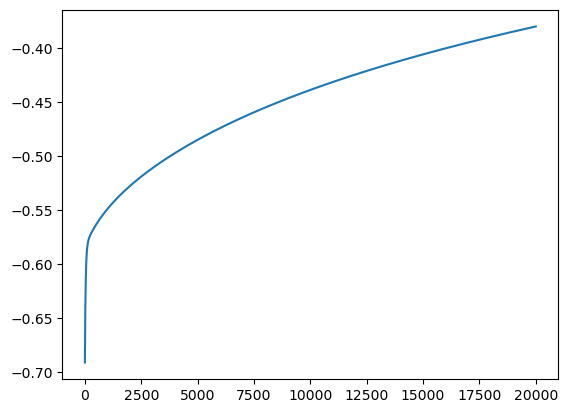

In [ ]:
_= plt.plot(l_agg)

# Validating the Data

In [ ]:
y_val_output = forward(X_val_mybag)

In [ ]:
y_val_class = give_class(y_val_output, 280)

In [ ]:
y_test_output = forward(X_test_mybag)

In [ ]:
y_test_class = give_class(y_test_output, 1400)